<span style="color:orange;font-size:30px">1. Problem definition</span>

The goal of the project is to create a model that can predict who among the Titanic's passengers survived the disaster and who did not.
The assumption is made that this is a classification problem.

<span style="color:orange;font-size:30px">2. Data collection</span>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import titanic_tools

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [5]:
titanic_train = titanic_tools.load_dataset("data/train.csv")
titanic_test = titanic_tools.load_dataset("data/test.csv")
titanic_test

<span style="color:orange;font-size:30px">3. Data analysis</span>

In [6]:
titanic_train.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

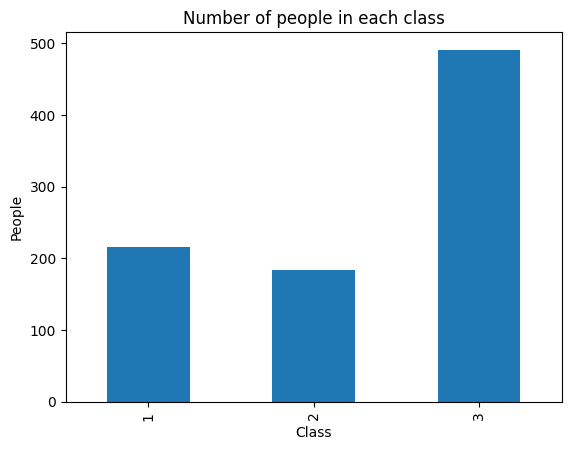

In [ ]:
pclass = titanic_train.Pclass.value_counts().sort_index()

pclass.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("People")
plt.title("Number of people in each class")
plt.show()


In [ ]:
counts = titanic_train.groupby(["Pclass"])["Survived"].value_counts()

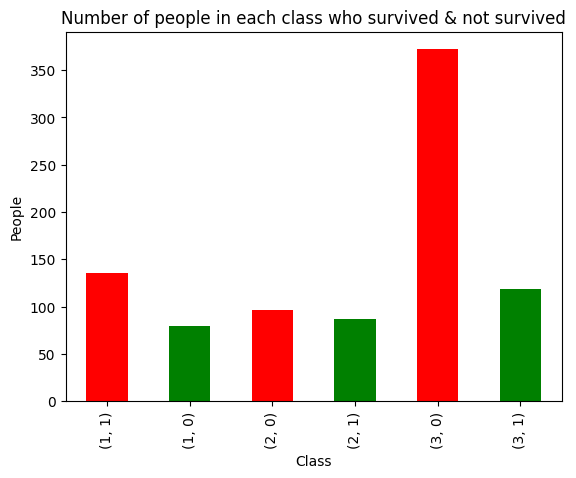

In [ ]:
# TODO fix beginning order
counts.plot(kind="bar", color=["red", "green"])
plt.xlabel("Class")
plt.ylabel("People")
plt.title("Number of people in each class who survived & not survived")
plt.show()

<span style="color:orange;font-size:30px">4. Data preparation</span>

Handle NaN values

In [ ]:
titanic_train[titanic_train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
mode = titanic_train.Embarked.value_counts()
print(mode)
titanic_train["Embarked"].fillna("S", inplace=True)

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [ ]:
median = titanic_train.Age.median()
titanic_train["Age"].fillna(median, inplace=True)

In [ ]:
titanic_train.drop(labels="Cabin", axis=1, inplace=True)

In [ ]:
titanic_train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Encoding